# DATA602 PROJECT - BANKCHURN PREDICTION SYSTEM

## Authors

| Name                     | UID        | Email                    |
|--------------------------|------------|--------------------------|
| Balaji Ajay Kumar Madana   | 121971692  | ajayk30@umd.edu         |
| Samarth Prakash     | 121974495  | samp8055@umd.edu         |
| Harsha Challapalli      | 121943866  | harrsha@umd.edu       |
| Yashwanth Sathianarayanan      | 122246980  | ysathian@umd.edu          |


This notebook contains two parts PART A and PART B.
#### PART A : DATA PREPROCESSING, EXPLORATION, STATISTICS,TESTING, AND VISUALISATION. 
#### PART B : MACHINE LEARNING ANALYSIS, LLM ( Langchain + Groq ),Gradio. 

## PART A

In [74]:
# Importing necessary libraries
import pandas as pd                    
import numpy as np                     
from matplotlib import pyplot as plt   
import seaborn as sns
import time
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [75]:
data = "churn.csv"
df = pd.read_csv(data)

In [76]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [77]:
print("Shape and data types of the dataset : \n")
print(f"shape :{df.shape}")
print(f"Data Types:\n{df.dtypes}")

Shape and data types of the dataset : 

shape :(10000, 14)
Data Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [78]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

In [79]:
# Percentage of missing values in the dataset

missing_count = df.isnull().sum()
missing_percentage = (missing_count / len(df)) * 100
print(f"Missing values in the dataset : {missing_percentage}")

Missing values in the dataset : RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64


In [80]:
# duplicates
dupes = df.duplicated().sum()
print("Total exact duplicate rows:", dupes)

Total exact duplicate rows: 0


In [81]:
# duplicates by CustomerId
dupes_id = df.duplicated(subset=["CustomerId"]).sum()
print("Duplicate CustomerId rows:", dupes_id)

Duplicate CustomerId rows: 0


In [82]:
# outlier detection
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[num_cols].describe()


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


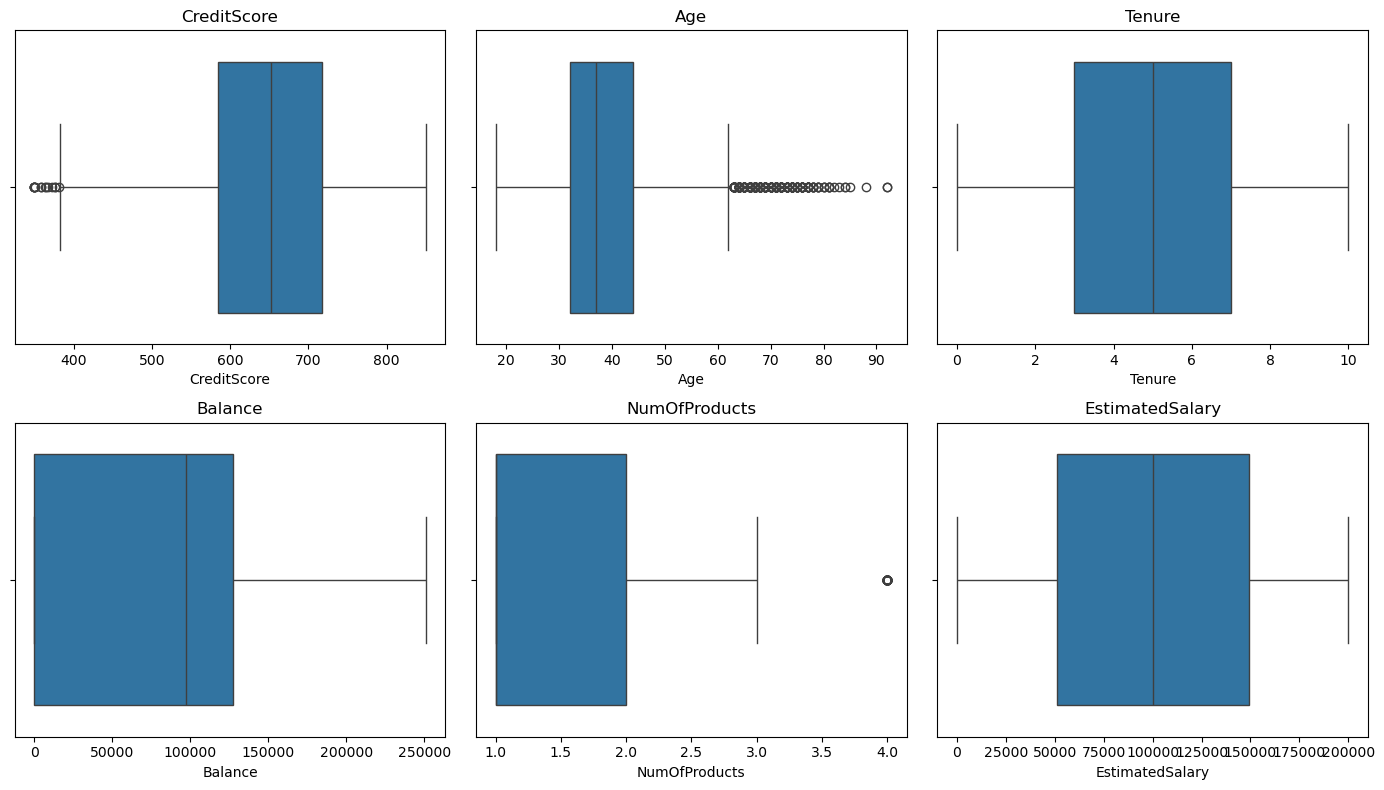

In [83]:
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(data=df, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()


In [84]:
"""
Instead of dropping rows (which may remove valid high-value customers), we cap them to reasonable bounds.
1. CreditScore:
Small number of low end outliers (~<400).
These may represent very low-credit customers, but are still realistic.

2. Age:
Noticeable right-side outliers (>65–90).
These are few but extreme, may bias scaling or model weights.
We apply iqr capping to cap them for reasonable bounds as they age also plays an important role.

3. Tenure, Balance and EstimatedSalary: Clean and no outliers.

4.  NumOfProducts:
One clear outlier (value = 4). We keep it as it is a valid business case (some customers have multiple products).
"""

def cap_iqr(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return series.clip(lower, upper)

df['Age'] = cap_iqr(df['Age'])


### Handle categorical variables

In [86]:
print(set(df["Gender"]))

{'Male', 'Female'}


In [87]:
"""
The variable "Gender" has only two values ("Male", "Female").
"""

'\nThe variable "Gender" has only two values ("Male", "Female").\n'

In [88]:
df.rename(columns={"Gender":"IsMale"}, inplace=True)
df.replace(to_replace={"IsMale":{"Male":1,"Female":0}}, inplace=True)

print(set(df["IsMale"]))

{0, 1}


/var/folders/gh/4t48940x6h7gcccrv59xkhph0000gn/T/ipykernel_27019/269061009.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace={"IsMale":{"Male":1,"Female":0}}, inplace=True)


In [89]:
print(set(df["Geography"]))

{'France', 'Spain', 'Germany'}


In [90]:
# The variable "Geography" represents the country of the customer, and it has three values ("France", "Germany", "Spain").
#"One-Hot-Encoding" (OHE) to assign a set of logical numbers (0 or 1) to each country.

In [91]:
df = df.drop(columns=["CustomerId", "Surname", "RowNumber"])
#The above columns simply produce  noise so we remove them

In [92]:
# Rename "Geography" as "Country"
df.rename(columns={"Geography":"Country", "Exited":"Churn"}, inplace=True)

# Separate numerical variables (to be normalized) and categorical variables (for one-hot-encoding)
NumericalData   = df.select_dtypes("number")
CategoricalData = df.select_dtypes("object")

print(CategoricalData.columns)

Index(['Country'], dtype='object')


In [93]:
OHE = pd.get_dummies(CategoricalData)
OHE = OHE.astype("int64")
OHE.head()

,Country_France,Country_Germany,Country_Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [94]:
BankChurn = pd.concat([CategoricalData,OHE,NumericalData], axis=1)
display(BankChurn)

,Country,Country_France,Country_Germany,Country_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,France,1,0,0,619,0,42,2,0.00,1,1,1,101348.88,1
1,Spain,0,0,1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,France,1,0,0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,France,1,0,0,699,0,39,1,0.00,2,0,0,93826.63,0
4,Spain,0,0,1,850,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,France,1,0,0,771,1,39,5,0.00,2,1,0,96270.64,0
9996,France,1,0,0,516,1,35,10,57369.61,1,1,1,101699.77,0
9997,France,1,0,0,709,0,36,7,0.00,1,0,1,42085.58,1
9998,Germany,0,1,0,772,1,42,3,75075.31,2,1,0,92888.52,1


In [95]:
BankChurn.isna().sum()

Country            0
Country_France     0
Country_Germany    0
Country_Spain      0
CreditScore        0
IsMale             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
dtype: int64

# Data Exploration and Summary Statistics

In [97]:
df = BankChurn
df.head(5)


,Country,Country_France,Country_Germany,Country_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,France,1,0,0,619,0,42,2,0.00,1,1,1,101348.88,1
1,Spain,0,0,1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,France,1,0,0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,France,1,0,0,699,0,39,1,0.00,2,0,0,93826.63,0
4,Spain,0,0,1,850,0,43,2,125510.82,1,1,1,79084.10,0


In [98]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          10000 non-null  object 
 1   Country_France   10000 non-null  int64  
 2   Country_Germany  10000 non-null  int64  
 3   Country_Spain    10000 non-null  int64  
 4   CreditScore      10000 non-null  int64  
 5   IsMale           10000 non-null  int64  
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Churn            10000 non-null  int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 1.1+ MB


,Country_France,Country_Germany,Country_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.501400,0.250900,0.247700,650.528800,0.545700,38.660800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,0.500023,0.433553,0.431698,96.653299,0.497932,9.746704,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,0.000000,0.000000,0.000000,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,0.000000,0.000000,0.000000,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.000000,0.000000,0.000000,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.000000,1.000000,0.000000,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.000000,1.000000,1.000000,850.000000,1.000000,62.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [99]:
df.shape

(10000, 14)

### Distribution Analysis (Descriptive Statistics)


<Axes: xlabel='Age', ylabel='Count'>

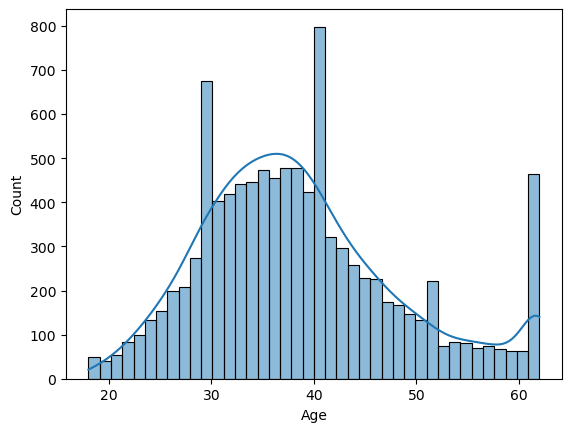

In [101]:
sns.histplot(df['Age'], kde=True)

The Age distribution shows bimodal behavior with two distinct peaks: one around age 30-35 (680 customers) and another larger peak around age 40 (800 customers). There's also a notable spike around age 65 (470 customers), likely representing recent retirees. The distribution suggests the bank's customer base is primarily middle-aged (30-50 years old), with relatively fewer young adults (under 25) and seniors (over 55). This bimodal pattern could indicate two different customer segments or cohorts within your dataset.

In [103]:
Cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
Bins = [50, 25, 25, 25, 20, 50]

sns.set_style("whitegrid")
sns.set_palette("coolwarm")

### Histograms  Distribution of Features by Churn Status

HISTOGRAMS: Non-Churned Customers (Churn = 0)


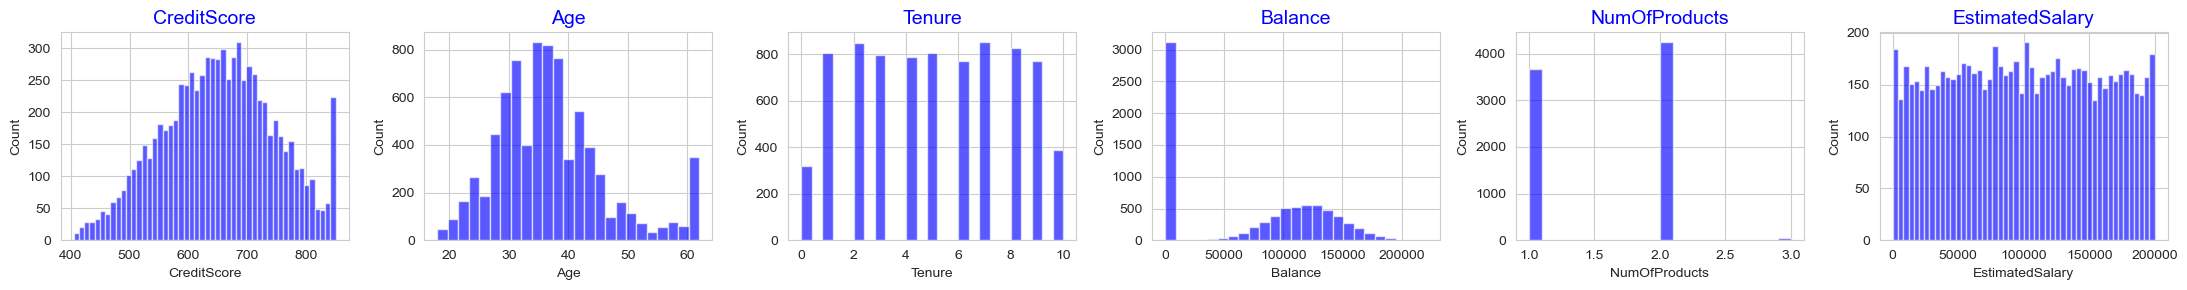

In [105]:
# Histograms for Non-Churned Customers (Churn = 0)
print("=" * 50)
print("HISTOGRAMS: Non-Churned Customers (Churn = 0)")
print("=" * 50)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 3))

for i, col in enumerate(Cols):
    ax[i].hist(BankChurn.loc[BankChurn["Churn"] == 0, col], 
               bins=Bins[i], color="blue", alpha=0.65)
    ax[i].set_title(col, fontsize=14, color="blue")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

HISTOGRAMS: Churned Customers (Churn = 1)


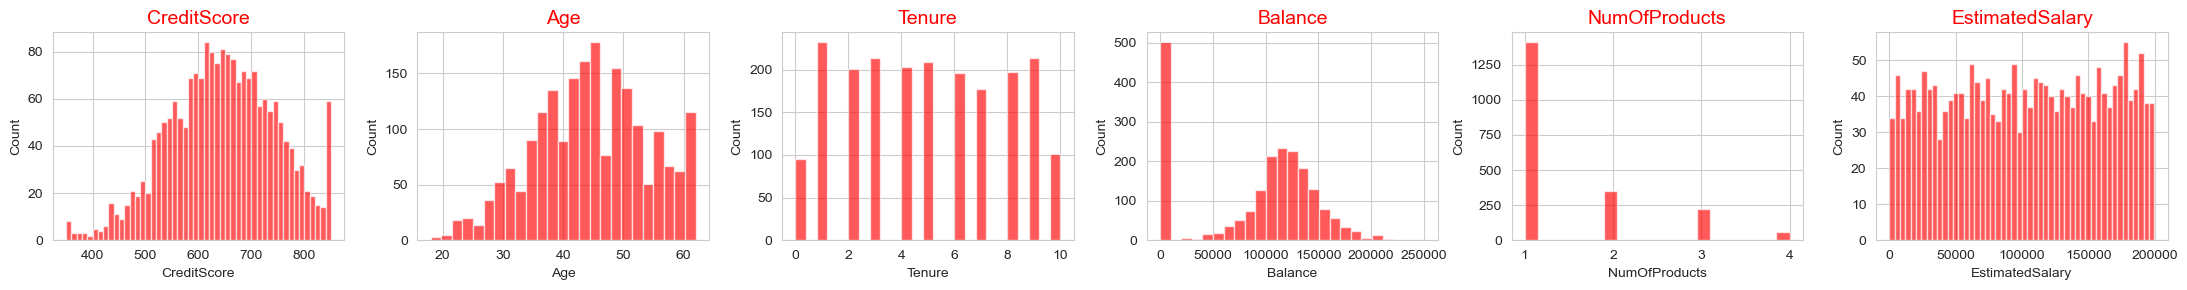

In [106]:
# Histograms for Churned Customers (Churn = 1)
print("=" * 50)
print("HISTOGRAMS: Churned Customers (Churn = 1)")
print("=" * 50)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 3))

for i, col in enumerate(Cols):
    ax[i].hist(BankChurn.loc[BankChurn["Churn"] == 1, col], 
               bins=Bins[i], color="red", alpha=0.65)
    ax[i].set_title(col, fontsize=14, color="red")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

### BOXPLOTS: Spread and Outliers of Features by Churn Status

BOXPLOTS: Non-Churned Customers (Churn = 0)


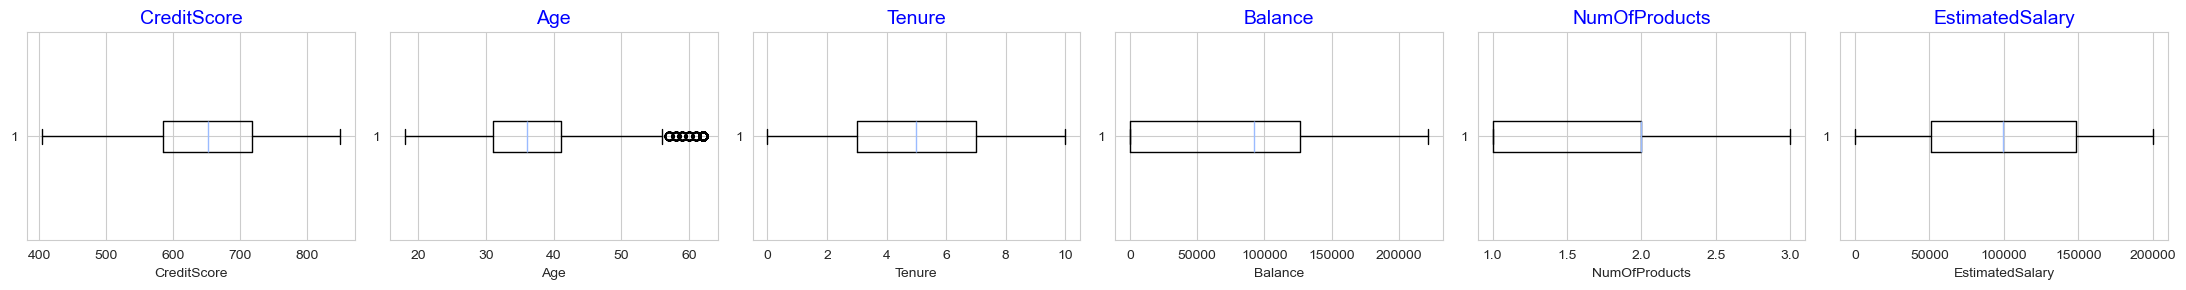

In [108]:
#  Boxplots for Non-Churned Customers (Churn = 0)
print("=" * 50)
print("BOXPLOTS: Non-Churned Customers (Churn = 0)")
print("=" * 50)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 3))

for i, col in enumerate(Cols):
    ax[i].boxplot(BankChurn.loc[BankChurn["Churn"] == 0, col], vert=False)
    ax[i].set_title(col, fontsize=14, color="blue")
    ax[i].set_xlabel(col)

plt.tight_layout()
plt.show()

BOXPLOTS: Churned Customers (Churn = 1)


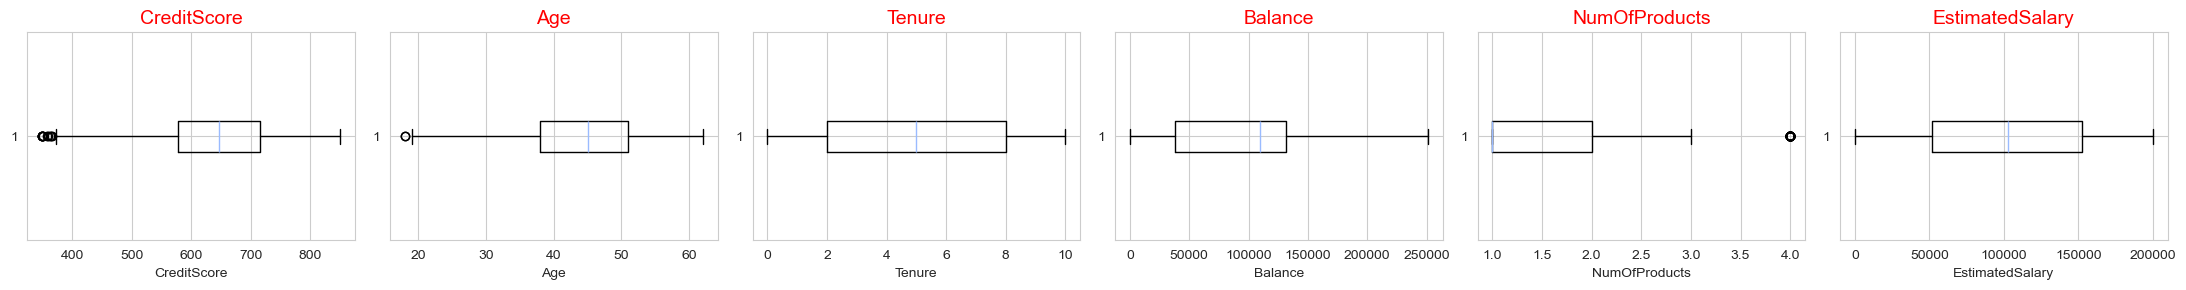

In [109]:

# Boxplots for Churned Customers (Churn = 1)
print("=" * 50)
print("BOXPLOTS: Churned Customers (Churn = 1)")
print("=" * 50)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(22, 3))

for i, col in enumerate(Cols):
    ax[i].boxplot(BankChurn.loc[BankChurn["Churn"] == 1, col], vert=False)
    ax[i].set_title(col, fontsize=14, color="red")
    ax[i].set_xlabel(col)

plt.tight_layout()
plt.show()


If we look at the histograms and boxplots of non-churned vs. churned customers, we can discern some notable trends that would get us to some good predictors. The Age distributions show notable differences among churned (Churn=1) vs. non-churned (Churn=0) customers, suggesting that Age will be one of the main predictors of customer churn. Similarly, the Balance variable also exhibits varying patterns of distribution for the two groups, which indicate that account balance may be a critical factor in deciding whether a customer churns or not. On the other hand, CreditScore has extremely comparable distributions for non-churned and churned customers, indicating that it may not be very helpful in predicting churn for our model. This same observation applies to Tenure, NumOfProducts, and EstimatedSalary as well - all three variables show relatively similar distribution patterns regardless of churn status, meaning they might have limited predictive power when it comes to identifying customers at risk of leaving. These initial visual insights will help us focus on the most promising features when building our predictive model.

###  Correlation Between the Variables

In [112]:
df = df.drop(columns=["Country"])

In [113]:
corr_matrix = df.corr(method="pearson")

print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 Country_France  Country_Germany  Country_Spain  CreditScore  \
Country_France         1.000000        -0.580359      -0.575418    -0.008928   
Country_Germany       -0.580359         1.000000      -0.332084     0.005538   
Country_Spain         -0.575418        -0.332084       1.000000     0.004780   
CreditScore           -0.008928         0.005538       0.004780     1.000000   
IsMale                 0.006772        -0.024628       0.016889    -0.002857   
Age                   -0.042976         0.050767      -0.001207    -0.007952   
Tenure                -0.002848        -0.000567       0.003868     0.000842   
Balance               -0.231329         0.401110      -0.134892     0.006268   
NumOfProducts          0.001230        -0.010419       0.009039     0.012238   
HasCrCard              0.002467         0.010577      -0.013480    -0.005458   
IsActiveMember         0.003317        -0.020486       0.016732     0.025651   
EstimatedSalary     

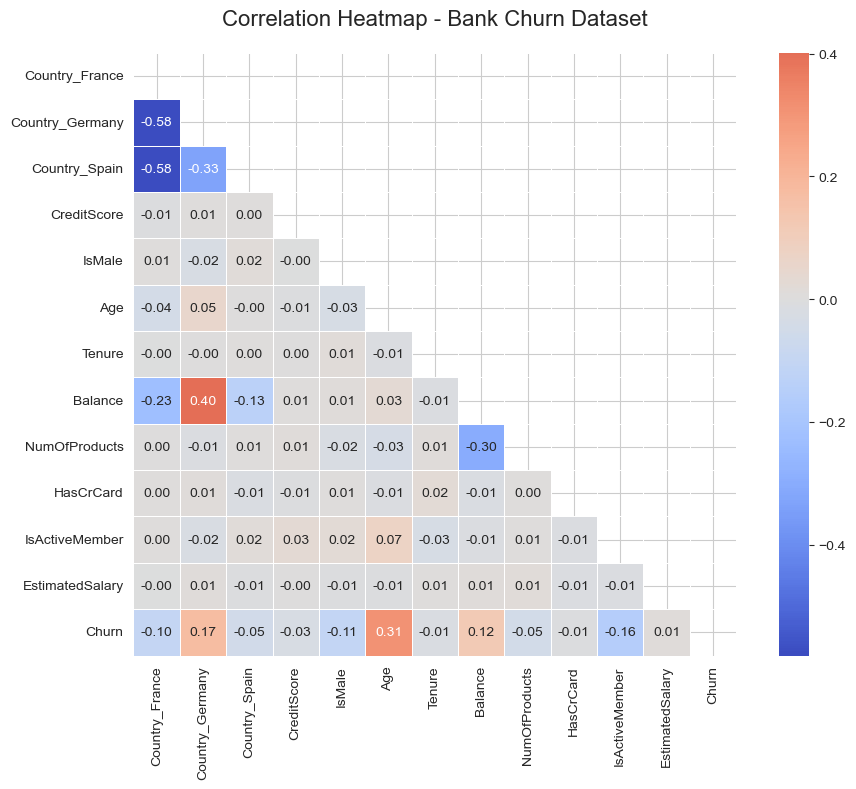

In [114]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask,                    
            cmap="coolwarm",                        
            fmt="0.2f",          
            annot=True,                
            center=0.0,                  
            square=True,              
            linewidths=0.5)      

plt.title("Correlation Heatmap - Bank Churn Dataset", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

 "Age" has the strongest correlation with "Churn", followed by the variables "IsActiveMember", "Balance", and "IsMale".

The variables "NumOfProducts" and "Balance" have a strong negative correlation between themselves, but this is not relavant to the outcome variable "Churn".



### Two-Sample T-Test  Age vs Churn

In [117]:

from scipy.stats import ttest_ind


age_churned = df.loc[BankChurn['Churn'] == 1, 'Age']
age_not_churned = df.loc[BankChurn['Churn'] == 0, 'Age']


mean_churned = age_churned.mean()
mean_not_churned = age_not_churned.mean()
std_churned = age_churned.std()
std_not_churned = age_not_churned.std()

print("=" * 60)
print("TWO-SAMPLE T-TEST: Age vs Churn")
print("=" * 60)
print(f"Churned Customers (n={len(age_churned)}):")
print(f"  Mean Age: {mean_churned:.2f} years")
print(f"  Std Dev: {std_churned:.2f} years\n")

print(f"Non-Churned Customers (n={len(age_not_churned)}):")
print(f"  Mean Age: {mean_not_churned:.2f} years")
print(f"  Std Dev: {std_not_churned:.2f} years\n")

print(f"Difference in Means: {mean_churned - mean_not_churned:.2f} years\n")

# Perform two-sample t-test
t_stat, p_value = ttest_ind(age_churned, age_not_churned)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Conclusion
alpha = 0.05
print("\n" + "=" * 60)
print("CONCLUSION:")
print("=" * 60)
if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < α ({alpha}), we REJECT the null hypothesis.")
    print(f"\nThere IS a statistically significant difference in mean Age between")
    print(f"churned and non-churned customers.")
    if mean_churned > mean_not_churned:
        print(f"\nChurned customers are on average {mean_churned - mean_not_churned:.2f} years OLDER.")
        print("This suggests that older customers are more likely to churn.")
    else:
        print(f"\nChurned customers are on average {mean_not_churned - mean_churned:.2f} years YOUNGER.")
        print("This suggests that younger customers are more likely to churn.")
else:
    print(f"Since p-value ({p_value:.6f}) >= α ({alpha}), we FAIL TO REJECT the null hypothesis.")
    print("\nThere is NO statistically significant difference in mean Age between the two groups.")

TWO-SAMPLE T-TEST: Age vs Churn
Churned Customers (n=2037):
  Mean Age: 44.68 years
  Std Dev: 9.42 years

Non-Churned Customers (n=7963):
  Mean Age: 37.12 years
  Std Dev: 9.22 years

Difference in Means: 7.56 years

T-Statistic: 32.8868
P-value: 0.000000

CONCLUSION:
Since p-value (0.000000) < α (0.05), we REJECT the null hypothesis.

There IS a statistically significant difference in mean Age between
churned and non-churned customers.

Churned customers are on average 7.56 years OLDER.
This suggests that older customers are more likely to churn.


### Multiple T-Tests (Continuous Variables vs Churn)

Test if continuous variables have significantly different means for churned vs non-churned customers.

In [120]:

from scipy.stats import ttest_ind

# List of continuous variables to test
continuous_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

print("=" * 60)
print("TWO-SAMPLE T-TESTS: Continuous Variables vs Churn")
print("=" * 60)


results = []

for var in continuous_vars:
    print(f"\n{'=' * 60}")
    print(f"Testing: {var} vs Churn")
    print('=' * 60)
    

    var_churned = df.loc[BankChurn['Churn'] == 1, var]
    var_not_churned = df.loc[BankChurn['Churn'] == 0, var]
    
    # Calculate statistics
    mean_churned = var_churned.mean()
    mean_not_churned = var_not_churned.mean()
    std_churned = var_churned.std()
    std_not_churned = var_not_churned.std()
    
    print(f"\nChurned: Mean = {mean_churned:.2f}, Std = {std_churned:.2f}")
    print(f"Not Churned: Mean = {mean_not_churned:.2f}, Std = {std_not_churned:.2f}")
    print(f"Difference: {mean_churned - mean_not_churned:.2f}")
    

    t_stat, p_value = ttest_ind(var_churned, var_not_churned)
    
    print(f"\nT-Statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    

    alpha = 0.05
    significant = "Yes" if p_value < alpha else "No"
    results.append({
        'Variable': var,
        'Mean_Churned': mean_churned,
        'Mean_Not_Churned': mean_not_churned,
        'Difference': mean_churned - mean_not_churned,
        'P-value': p_value,
        'Significant': significant
    })
    

    print("\nConclusion:")
    if p_value < alpha:
        print(f"P-value ({p_value:.6f}) < α ({alpha}) → SIGNIFICANT difference")
    else:
        print(f"P-value ({p_value:.6f}) >= α ({alpha}) → NO significant difference")

# Summary table
print("\n" + "=" * 60)
print("SUMMARY TABLE:")
print("=" * 60)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n" + "=" * 60)
print("OVERALL CONCLUSION:")
print("=" * 60)
print("Variables marked 'Yes' under 'Significant' show statistically significant")
print("differences between churned and non-churned customers, making them")
print("potentially useful predictors for churn.")

TWO-SAMPLE T-TESTS: Continuous Variables vs Churn

Testing: CreditScore vs Churn

Churned: Mean = 645.35, Std = 100.32
Not Churned: Mean = 651.85, Std = 95.65
Difference: -6.50

T-Statistic: -2.7101
P-value: 0.006738

Conclusion:
P-value (0.006738) < α (0.05) → SIGNIFICANT difference

Testing: Age vs Churn

Churned: Mean = 44.68, Std = 9.42
Not Churned: Mean = 37.12, Std = 9.22
Difference: 7.56

T-Statistic: 32.8868
P-value: 0.000000

Conclusion:
P-value (0.000000) < α (0.05) → SIGNIFICANT difference

Testing: Tenure vs Churn

Churned: Mean = 4.93, Std = 2.94
Not Churned: Mean = 5.03, Std = 2.88
Difference: -0.10

T-Statistic: -1.4001
P-value: 0.161527

Conclusion:
P-value (0.161527) >= α (0.05) → NO significant difference

Testing: Balance vs Churn

Churned: Mean = 91108.54, Std = 58360.79
Not Churned: Mean = 72745.30, Std = 62848.04
Difference: 18363.24

T-Statistic: 11.9362
P-value: 0.000000

Conclusion:
P-value (0.000000) < α (0.05) → SIGNIFICANT difference

Testing: EstimatedSalar

In [121]:
df.head()

,Country_France,Country_Germany,Country_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,1,0,0,619,0,42,2,0.00,1,1,1,101348.88,1
1,0,0,1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,1,0,0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,1,0,0,699,0,39,1,0.00,2,0,0,93826.63,0
4,0,0,1,850,0,43,2,125510.82,1,1,1,79084.10,0


### Over-representation analysis for categorical variables

In [123]:

categorical_vars = ['Country_France', 'Country_Germany', 'Country_Spain', 
                    'IsMale', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

for var in categorical_vars:
    print("=" * 60)
    print(f"Variable: {var}")
    print("=" * 60)
    

    contingency_pct = pd.crosstab(df[var], df['Churn'], normalize='columns') * 100
    
    print("\nPercentage Distribution:")
    print(contingency_pct.round(2))
    
    # Check over-representation
    print(f"\n{'Category':<15} {'Not Churned %':<15} {'Churned %':<15} {'Status'}")
    print("-" * 60)
    
    for category in contingency_pct.index:
        pct_not_churned = contingency_pct.loc[category, 0]
        pct_churned = contingency_pct.loc[category, 1]
        ratio = pct_churned / pct_not_churned if pct_not_churned > 0 else 0
        
        if ratio > 1.2:
            status = "OVER-represented"
        elif ratio < 0.8:
            status = "UNDER-represented"
        else:
            status = "Balanced"
            
        print(f"{str(category):<15} {pct_not_churned:<15.2f} {pct_churned:<15.2f} {status}")
    
    print("\n")

Variable: Country_France

Percentage Distribution:
Churn               0      1
Country_France              
0               47.21  60.24
1               52.79  39.76

Category        Not Churned %   Churned %       Status
------------------------------------------------------------
0               47.21           60.24           OVER-represented
1               52.79           39.76           UNDER-represented


Variable: Country_Germany

Percentage Distribution:
Churn                0      1
Country_Germany              
0                78.71  60.04
1                21.29  39.96

Category        Not Churned %   Churned %       Status
------------------------------------------------------------
0               78.71           60.04           UNDER-represented
1               21.29           39.96           OVER-represented


Variable: Country_Spain

Percentage Distribution:
Churn              0      1
Country_Spain              
0              74.08  79.73
1              25.92  20.27

If the churned share is 20% higher than the non-churned share → mark as over-represented.

If it’s 20% lower → mark as under-represented.

Anything in between → roughly balanced.

# Data Preprocessing

In [126]:

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_temp, X_valid, y_temp, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Validation set size:", X_valid.shape)


Training set size: (8100, 12)
Testing set size: (900, 12)
Validation set size: (1000, 12)


In [127]:
display(X_train)

,Country_France,Country_Germany,Country_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3784,1,0,0,640,0,31,9,138857.59,1,1,0,48640.77
6652,1,0,0,827,1,38,5,0.00,2,0,0,103305.01
4587,1,0,0,500,0,34,6,0.00,1,1,1,140268.45
7084,0,1,0,805,1,56,6,151802.29,1,1,0,46791.09
2847,0,0,1,529,1,38,7,99842.50,2,1,0,90256.06
...,...,...,...,...,...,...,...,...,...,...,...,...
9296,0,1,0,586,0,56,9,100781.75,2,1,1,54448.41
3645,1,0,0,788,1,55,3,0.00,1,0,1,13288.46
5008,1,0,0,534,1,36,4,120037.96,1,1,0,36275.94
4343,0,1,0,549,1,54,5,92877.33,1,1,0,2619.64


### 5.2. Feature Scaling

ML models are sensitive to scale of the data, so it is important to scale each and every feature.

In [130]:
X_train.dtypes

Country_France       int64
Country_Germany      int64
Country_Spain        int64
CreditScore          int64
IsMale               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [131]:
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

In [132]:
scaler = StandardScaler()

In [133]:
# Fit scaler on training numeric columns
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])
X_valid_scaled[num_cols] = scaler.transform(X_valid[num_cols])


print("Scaled columns:", num_cols)
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)
print("Validation set shape:", X_valid_scaled.shape)

Scaled columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Training set shape: (8100, 12)
Testing set shape: (900, 12)
Validation set shape: (1000, 12)


In [134]:
import joblib
final_df = X_train_scaled.copy()
final_df["Churn"] = y_train.values
final_df.to_csv("processed_bank_churn.csv", index=False)

In [192]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

# Conclusion Part A
From the visual analysis (histograms and boxplots), Age and Balance show clear
differences between churned and non-churned customers, making them strong
predictors of churn.
CreditScore, Tenure, NumOfProducts, and EstimatedSalary have similar
distributions for both churn groups, suggesting they may not be very usef
ul for
prediction.
Correlation analysis shows that Age has the strongest correlation with Churn,
followed by IsActiveMember, Balance, and IsMale.
A strong negative correlation exists between NumOfProducts and Balance, but it
is not directly related to Churn.
The Age distribution is bimodal, with peaks around 30–35 and 40 years, and
another spike near 65 years, indicating two main customer segments—middle-aged
and nearing-retirement groups.
T-test results confirm that there is a statistically significant difference in Age,
Balance, and CreditScore between churned and non-churned customers (p <
0.05).
On average, churned customers are 7.56 years older than non-churned ones,
suggesting older customers are more likely to leave.
Tenure and EstimatedSalary do not show significant differences and will be
dropped from the dataset.
Final takeaway:
The most influential predictors of customer churn are Age, Balance, CreditScore,
and IsActiveMember. These features will be prioritized when building the predictive
model.

# PART B

# Project Checkpoint 3 PART 2 - Machine Learning Analysis and LLM Integration


This part offered here showcases an end-to-end machine learning process, from exploration and processing of data to building, assessment, and comparison of models. The aim of the analysis here would be to explore the patterns underlying the data, as well as the efficacy of various machine learning models on the same task. Various models are used here to compare strengths and weaknesses as well as aptness, thereby making the final decision of which top models to use.

In [45]:

import pandas as pd
import numpy as np
import joblib
import os
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

import sklearn
print("All imports successful!")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

All imports successful!
Scikit-learn: 1.5.2
Pandas: 2.2.2
NumPy: 1.26.4


We are going run our analysis on the preprocessed churn dataset which is procssed bank churn csv file

In [47]:
df = pd.read_csv('data/processed_bank_churn.csv')

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nChurn distribution:")
print(df['Churn'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset loaded: (8100, 13)

Columns: ['Country_France', 'Country_Germany', 'Country_Spain', 'CreditScore', 'IsMale', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churn']

First 3 rows:
   Country_France  Country_Germany  Country_Spain  CreditScore  IsMale  \
0               1                0              0    -0.111618       0   
1               1                0              0     1.830959       1   
2               1                0              0    -1.565954       0   

        Age    Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0 -0.779913  1.378786  1.006375      -0.911977          1               0   
1 -0.063481 -0.004997 -1.217802       0.807533          0               0   
2 -0.472870  0.340949 -1.217802      -0.911977          1               1   

   EstimatedSalary  Churn  
0        -0.890423      0  
1         0.062089      0  
2         0.706169      0  

Churn distribution:
Churn
0    6453
1    1647

In [49]:
scaler_path = Path('models/scaler.pkl')

if scaler_path.exists():
    scaler = joblib.load(scaler_path)
    print(f"Scaler loaded from {scaler_path}")
    print(f"   Scaler type: {type(scaler).__name__}")
else:
    print(f"ERROR: scaler.pkl not found at {scaler_path}")
    print("   This file should already exist. Check your setup.")
    raise FileNotFoundError(f"scaler.pkl not found")

Scaler loaded from models/scaler.pkl
   Scaler type: StandardScaler


Preparing for training and testing we split the preprocessed dataset for model analysis.

In [51]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f" Data prepared")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"\n   Feature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

 Data prepared
   Features shape: (8100, 12)
   Target shape: (8100,)

   Feature columns (12):
    1. Country_France
    2. Country_Germany
    3. Country_Spain
    4. CreditScore
    5. IsMale
    6. Age
    7. Tenure
    8. Balance
    9. NumOfProducts
   10. HasCrCard
   11. IsActiveMember
   12. EstimatedSalary


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

In [55]:
print(f"\ Train-Test Split")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Train class distribution: {y_train.value_counts().to_dict()}")
print(f"   Test class distribution: {y_test.value_counts().to_dict()}")


\ Train-Test Split
   Training set: (6885, 12)
   Test set: (1215, 12)
   Train class distribution: {0: 5485, 1: 1400}
   Test class distribution: {0: 968, 1: 247}


### APPLY SMOTE

In [58]:
print("\n" + "="*70)
print("APPLYING SMOTE")
print("="*70)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE:  {y_train_smote.value_counts().to_dict()}")


APPLYING SMOTE
Before SMOTE: {0: 5485, 1: 1400}
After SMOTE:  {0: 5485, 1: 5485}


### APPLY ADASYN

In [61]:
print("\n" + "="*70)
print("APPLYING ADASYN")
print("="*70)

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print(f"Before ADASYN: {y_train.value_counts().to_dict()}")
print(f"After ADASYN:  {y_train_adasyn.value_counts().to_dict()}")


APPLYING ADASYN
Before ADASYN: {0: 5485, 1: 1400}
After ADASYN:  {0: 5485, 1: 5263}


### Helper Funtions

This cell defines the helper functions to train and evaluate a model.
grid search model It will perform hyperparameter tuning using GridSearchCV, using the F1 score as a primary metric, find the best model, and report the optimum parameter values.
Finally, evaluate_model evaluates the chosen model on the test set using all important classification metrics: Accuracy, Precision, Recall, F1-score, and ROC-AUC for consistent and comprehensive performance comparisons between models.

In [64]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:.4f}'}")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if isinstance(roc_auc, str) else roc_auc
    }

def grid_search_model(estimator, param_grid, X_train, y_train, X_test, y_test, model_name):
    """
    Perform GridSearchCV to find best model
    Returns best model and its evaluation metrics
    """
    print(f"\n{'='*70}")
    print(f"GridSearchCV: {model_name}")
    print(f"{'='*70}")
    print(f"Testing {len(param_grid)} parameter combinations...")
    
    start_time = time.time()
    
    # Use F1 score as primary metric (balances precision/recall)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    print(f"\nBest parameters found in {elapsed_time:.1f}s:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")
    print(f"\n   Best CV F1 Score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_model = grid_search.best_estimator_
    metrics = evaluate_model(best_model, X_test, y_test, model_name)
    
    return best_model, metrics, grid_search.best_params_

print("Helper functions defined!")


Helper functions defined!


### DEFINE HYPERPARAMETER GRIDS

This cell defines the hyperparameter search space for various  machine-learning algorithms.
For each model, a set of hyperparameters and corresponding values to search over are defined, and the number of unique combinations that will be searched can be computed in the code below.
Because the search space is so vast, GridSearchCV may take a long time to run or even run out of memory when all the combinations are searched simultaneously.
Alternatively, other hyperparameter tuning methods exist, including RandomizedSearchCV, which randomly samples a set number of hyperparameter combinations.

In [67]:
param_grids = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    
    'Decision Tree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 7, 10, 15],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [10, 20, 30],
            'criterion': ['gini', 'entropy']
        }
    },
    
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [8, 12, 15],
            'min_samples_leaf': [10, 20, 30],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    
    'SVM': {
        'estimator': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.1, 0.01],
            'kernel': ['rbf']
        }
    },
    
    'XGBoost': {
        'estimator': XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            use_label_encoder=False,
            enable_categorical=False
        ),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

for name, config in param_grids.items():
    n_combinations = 1
    for param_values in config['params'].values():
        n_combinations *= len(param_values)
    print(f"   {name}: {n_combinations} combinations")


   Logistic Regression: 8 combinations
   Decision Tree: 72 combinations
   Random Forest: 54 combinations
   KNN: 16 combinations
   SVM: 9 combinations
   XGBoost: 72 combinations


### TRAIN BEST MODELS - BASELINE (NO RESAMPLING)

In [70]:

import time
baseline_best_models = {}
baseline_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (Baseline)"
    )
    
    baseline_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    baseline_results.append(metrics)



GridSearchCV: Logistic Regression (Baseline)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.1s:
   C: 10
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.3756

Logistic Regression (Baseline)
Accuracy:  0.8091
Precision: 0.5773
Recall:    0.2267
F1 Score:  0.3256
ROC-AUC:   0.7680

GridSearchCV: Decision Tree (Baseline)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 1.0s:
   criterion: entropy
   max_depth: 7
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.5806

Decision Tree (Baseline)
Accuracy:  0.8519
Precision: 0.7913
Recall:    0.3684
F1 Score:  0.5028
ROC-AUC:   0.8388

GridSearchCV: Random Forest (Baseline)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 26.0s:
   max_depth: 12
   max_features: sqrt
   min_samples_leaf: 10

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /U


Best parameters found in 7.2s:
   colsample_bytree: 0.8
   learning_rate: 0.1
   max_depth: 3
   n_estimators: 200
   subsample: 1.0

   Best CV F1 Score: 0.5942

XGBoost (Baseline)
Accuracy:  0.8609
Precision: 0.7500
Recall:    0.4737
F1 Score:  0.5806
ROC-AUC:   0.8607


## Mitigation Using SMOTE and ADASYN
We applied SMOTE and ADASYN on this issue to model training. SMOTE generates synthetic
churned customers from their data points. ADASYN augments this process more by supplying
more synthetic samples of churned customers that are more difficult to classify. This allows the
model to center on harder cases.
Churned customers were better represented during training and the non-churn bias across mod-
els was reduced by applying these techniques. This helped make the models better at identifying
customers who are genuine and fairer.

### TRAIN BEST MODELS - SMOTE

In [75]:
smote_best_models = {}
smote_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train_smote,
        y_train=y_train_smote,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (SMOTE)"
    )
    
    smote_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    smote_results.append(metrics)



GridSearchCV: Logistic Regression (SMOTE)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.2s:
   C: 1
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.7512

Logistic Regression (SMOTE)
Accuracy:  0.7251
Precision: 0.3926
Recall:    0.6437
F1 Score:  0.4877
ROC-AUC:   0.7668

GridSearchCV: Decision Tree (SMOTE)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 1.9s:
   criterion: gini
   max_depth: 15
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.8223

Decision Tree (SMOTE)
Accuracy:  0.7811
Precision: 0.4682
Recall:    0.5668
F1 Score:  0.5128
ROC-AUC:   0.7801

GridSearchCV: Random Forest (SMOTE)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 46.0s:
   max_depth: 15
   max_features: sqrt
   min_samples_leaf: 10
   n_estimators: 

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /U


Best parameters found in 12.0s:
   colsample_bytree: 1.0
   learning_rate: 0.1
   max_depth: 7
   n_estimators: 300
   subsample: 0.8

   Best CV F1 Score: 0.8865

XGBoost (SMOTE)
Accuracy:  0.8412
Precision: 0.6286
Recall:    0.5344
F1 Score:  0.5777
ROC-AUC:   0.8340


### TRAIN BEST MODELS - ADASYN

In [78]:
adasyn_best_models = {}
adasyn_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train_adasyn,
        y_train=y_train_adasyn,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (ADASYN)"
    )
    
    adasyn_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    adasyn_results.append(metrics)


GridSearchCV: Logistic Regression (ADASYN)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.2s:
   C: 0.1
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.7226

Logistic Regression (ADASYN)
Accuracy:  0.7160
Precision: 0.3833
Recall:    0.6518
F1 Score:  0.4828
ROC-AUC:   0.7602

GridSearchCV: Decision Tree (ADASYN)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 2.1s:
   criterion: gini
   max_depth: 10
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.7703

Decision Tree (ADASYN)
Accuracy:  0.7547
Precision: 0.4294
Recall:    0.6275
F1 Score:  0.5099
ROC-AUC:   0.7848

GridSearchCV: Random Forest (ADASYN)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 48.2s:
   max_depth: 15
   max_features: sqrt
   min_samples_leaf: 10
   n_estim

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /U


Best parameters found in 12.0s:
   colsample_bytree: 1.0
   learning_rate: 0.2
   max_depth: 7
   n_estimators: 300
   subsample: 0.8

   Best CV F1 Score: 0.8802

XGBoost (ADASYN)
Accuracy:  0.8329
Precision: 0.6078
Recall:    0.5020
F1 Score:  0.5499
ROC-AUC:   0.8194


### COMPARE ALL APPROACHES & SELECT WINNERS

In [80]:
final_best_models = {}

for model_name in param_grids.keys():
    # Get F1 scores for each approach
    baseline_f1 = baseline_best_models[model_name]['metrics']['f1']
    smote_f1 = smote_best_models[model_name]['metrics']['f1']
    adasyn_f1 = adasyn_best_models[model_name]['metrics']['f1']
    
    # Find best approach
    scores = {
        'Baseline': (baseline_f1, baseline_best_models[model_name]),
        'SMOTE': (smote_f1, smote_best_models[model_name]),
        'ADASYN': (adasyn_f1, adasyn_best_models[model_name])
    }
    
    best_approach = max(scores.items(), key=lambda x: x[1][0])
    approach_name, (best_f1, best_config) = best_approach
    
    final_best_models[model_name] = {
        'approach': approach_name,
        'model': best_config['model'],
        'params': best_config['params'],
        'metrics': best_config['metrics']
    }
    
    print(f"\n{model_name}:")
    print(f"   Baseline F1: {baseline_f1:.4f}")
    print(f"   SMOTE F1:    {smote_f1:.4f}")
    print(f"   ADASYN F1:   {adasyn_f1:.4f}")
    print(f"   Winner:   {approach_name} (F1={best_f1:.4f})")



Logistic Regression:
   Baseline F1: 0.3256
   SMOTE F1:    0.4877
   ADASYN F1:   0.4828
   Winner:   SMOTE (F1=0.4877)

Decision Tree:
   Baseline F1: 0.5028
   SMOTE F1:    0.5128
   ADASYN F1:   0.5099
   Winner:   SMOTE (F1=0.5128)

Random Forest:
   Baseline F1: 0.5146
   SMOTE F1:    0.6030
   ADASYN F1:   0.5868
   Winner:   SMOTE (F1=0.6030)

KNN:
   Baseline F1: 0.4688
   SMOTE F1:    0.5133
   ADASYN F1:   0.5000
   Winner:   SMOTE (F1=0.5133)

SVM:
   Baseline F1: 0.5013
   SMOTE F1:    0.5442
   ADASYN F1:   0.5249
   Winner:   SMOTE (F1=0.5442)

XGBoost:
   Baseline F1: 0.5806
   SMOTE F1:    0.5777
   ADASYN F1:   0.5499
   Winner:   Baseline (F1=0.5806)


### SAVE BEST MODELS

In [85]:
os.makedirs('models', exist_ok=True)

model_filename_map = {
    'Logistic Regression': 'logistic_regression_smote_churn.pkl',
    'Decision Tree': 'decision_tree_smote_churn.pkl',
    'Random Forest': 'random_forest_smote_churn.pkl',
    'KNN': 'knn_smote_churn.pkl',
    'SVM': 'svm_smote_churn.pkl',
    'XGBoost': 'xgboost_smote_churn.pkl',
}

for model_name, config in final_best_models.items():
    filename = model_filename_map[model_name]
    path = f'models/{filename}'
    
    joblib.dump(config['model'], path, compress=3)
    size = os.path.getsize(path)
    
    print(f"\n {filename}")
    print(f"   Approach: {config['approach']}")
    print(f"   F1 Score: {config['metrics']['f1']:.4f}")
    print(f"   Recall:   {config['metrics']['recall']:.4f}")
    print(f"   Size:     {size:,} bytes")



 logistic_regression_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.4877
   Recall:   0.6437
   Size:     977 bytes

 decision_tree_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5128
   Recall:   0.5668
   Size:     22,361 bytes

 random_forest_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.6030
   Recall:   0.6518
   Size:     5,738,403 bytes

 knn_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5133
   Recall:   0.6235
   Size:     761,535 bytes

 svm_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5442
   Recall:   0.6235
   Size:     158,881 bytes

 xgboost_smote_churn.pkl
   Approach: Baseline
   F1 Score: 0.5806
   Recall:   0.4737
   Size:     41,930 bytes


### FINAL SUMMARY


 Best Models Ranked by F1 Score:
              Model Approach Accuracy Precision Recall F1 Score ROC-AUC
      Random Forest    SMOTE   0.8255    0.5610 0.6518   0.6030  0.8522
            XGBoost Baseline   0.8609    0.7500 0.4737   0.5806  0.8607
                SVM    SMOTE   0.7877    0.4828 0.6235   0.5442  0.7977
                KNN    SMOTE   0.7597    0.4363 0.6235   0.5133  0.7725
      Decision Tree    SMOTE   0.7811    0.4682 0.5668   0.5128  0.7801
Logistic Regression    SMOTE   0.7251    0.3926 0.6437   0.4877  0.7668

TRAINING COMPLETE!

Saved models:
  models/logistic_regression_smote_churn.pkl
  models/decision_tree_smote_churn.pkl
  models/random_forest_smote_churn.pkl
  models/knn_smote_churn.pkl
  models/svm_smote_churn.pkl
  models/xgboost_smote_churn.pkl


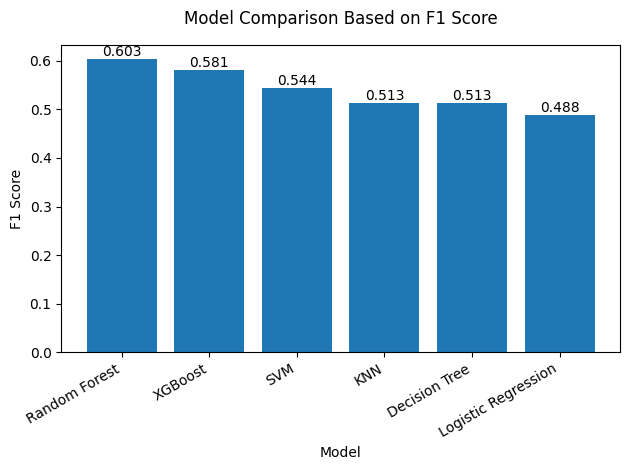

In [140]:
summary_data = []
for model_name, config in final_best_models.items():
    summary_data.append({
        'Model': model_name,
        'Approach': config['approach'],
        'Accuracy': f"{config['metrics']['accuracy']:.4f}",
        'Precision': f"{config['metrics']['precision']:.4f}",
        'Recall': f"{config['metrics']['recall']:.4f}",
        'F1 Score': f"{config['metrics']['f1']:.4f}",
        'ROC-AUC': f"{config['metrics']['roc_auc']:.4f}" if isinstance(config['metrics']['roc_auc'], float) else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1 Score', ascending=False)

print("\n Best Models Ranked by F1 Score:")
print(summary_df.to_string(index=False))

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print("\nSaved models:")
for filename in model_filename_map.values():
    print(f"  models/{filename}")

import matplotlib.pyplot as plt

plt.figure()

bars = plt.bar(
    summary_df['Model'],
    summary_df['F1 Score'].astype(float)
)

plt.title("Model Comparison Based on F1 Score", pad=15)
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=30, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()




The Random Forest model with SMOTE is the best overall model, with a F1 score of 0.6030 and strong recall of 0.5188 and competitive ROCAUC of 0.8522. This means it works best to fend for the best balance between correct detection of the churner and not overproducing false alarms that require it at high cost when they are trying to miss a churner.

One of the best choices is XGBoost Baseline with relatively good accuracy (0.8609) ROCAUC and slightly better recall (0.4737) and F1 score (0.5806). The business is only best served if it believes in overall accuracy and precision over churnrisk customers.

# Web Application

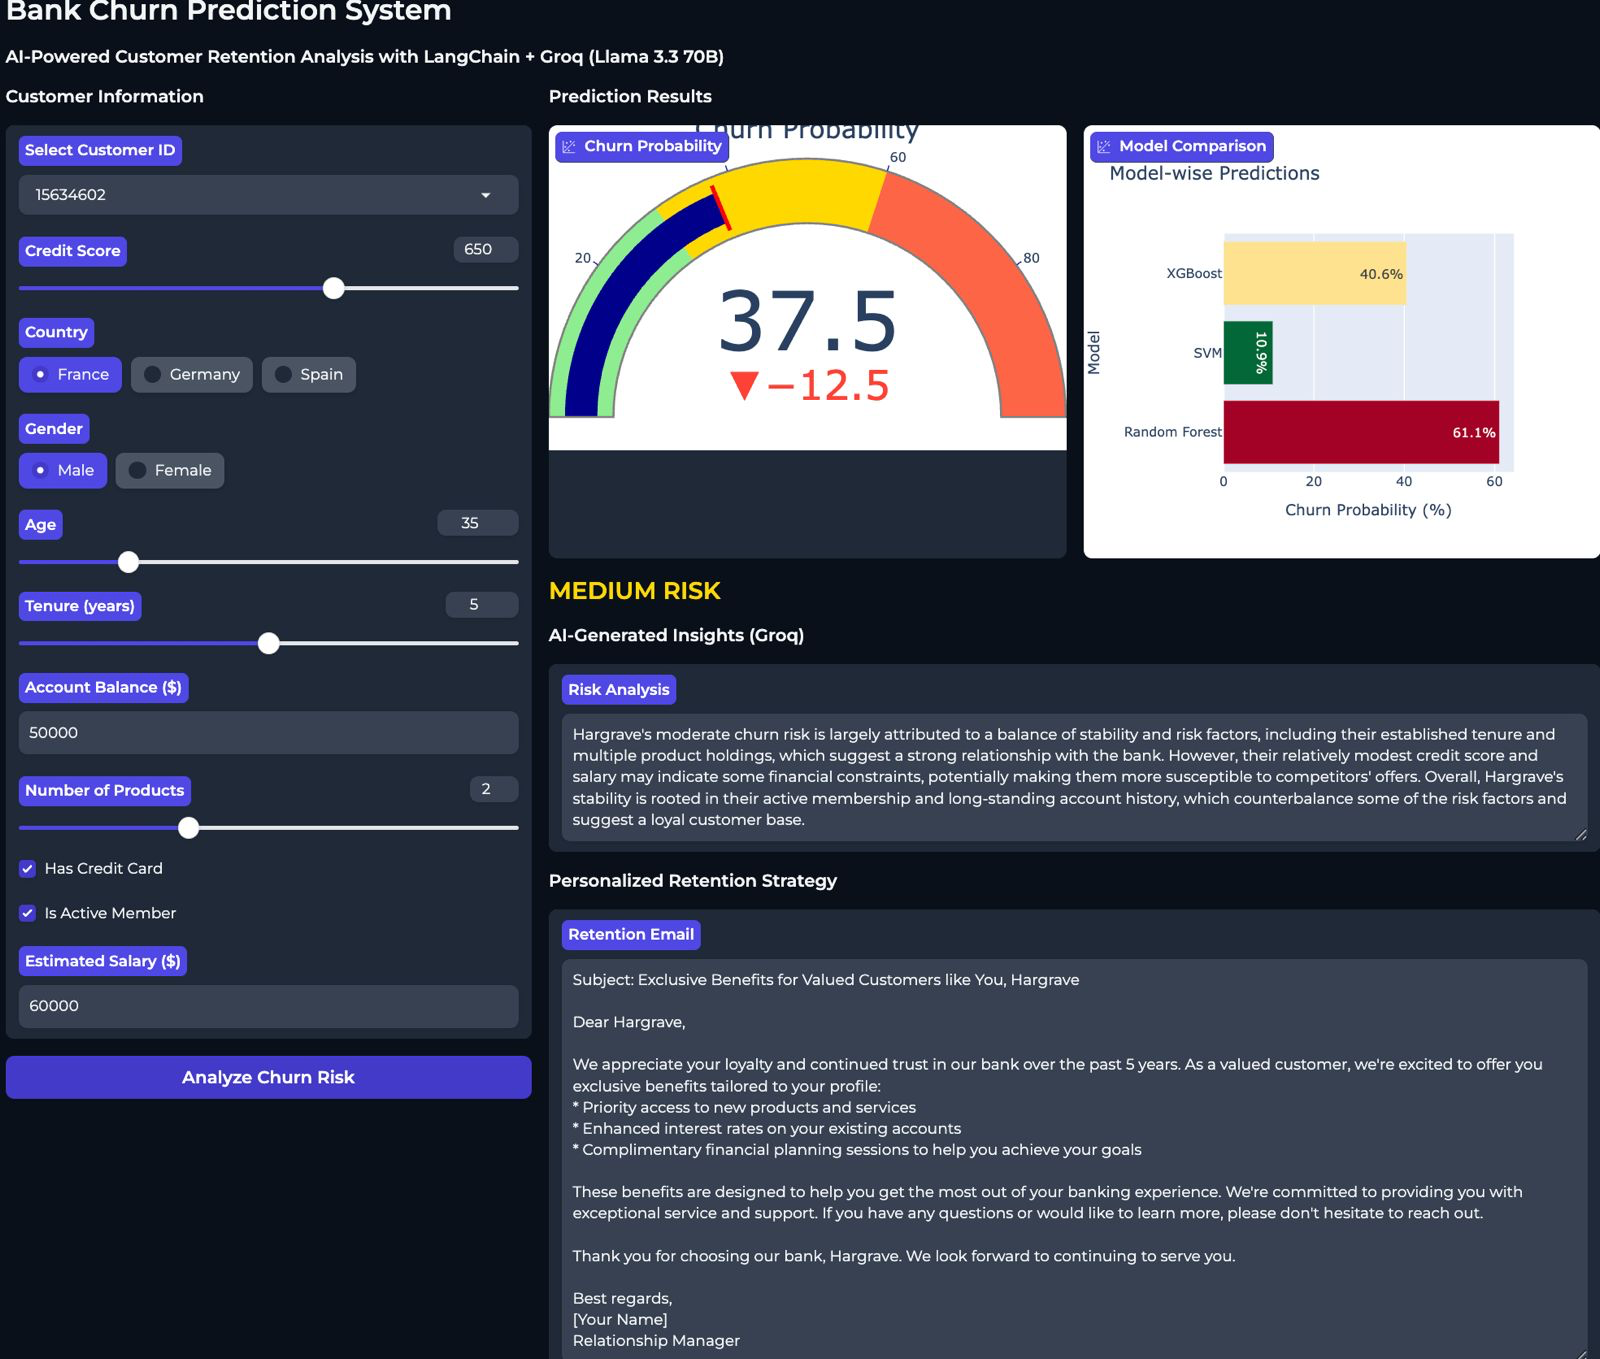

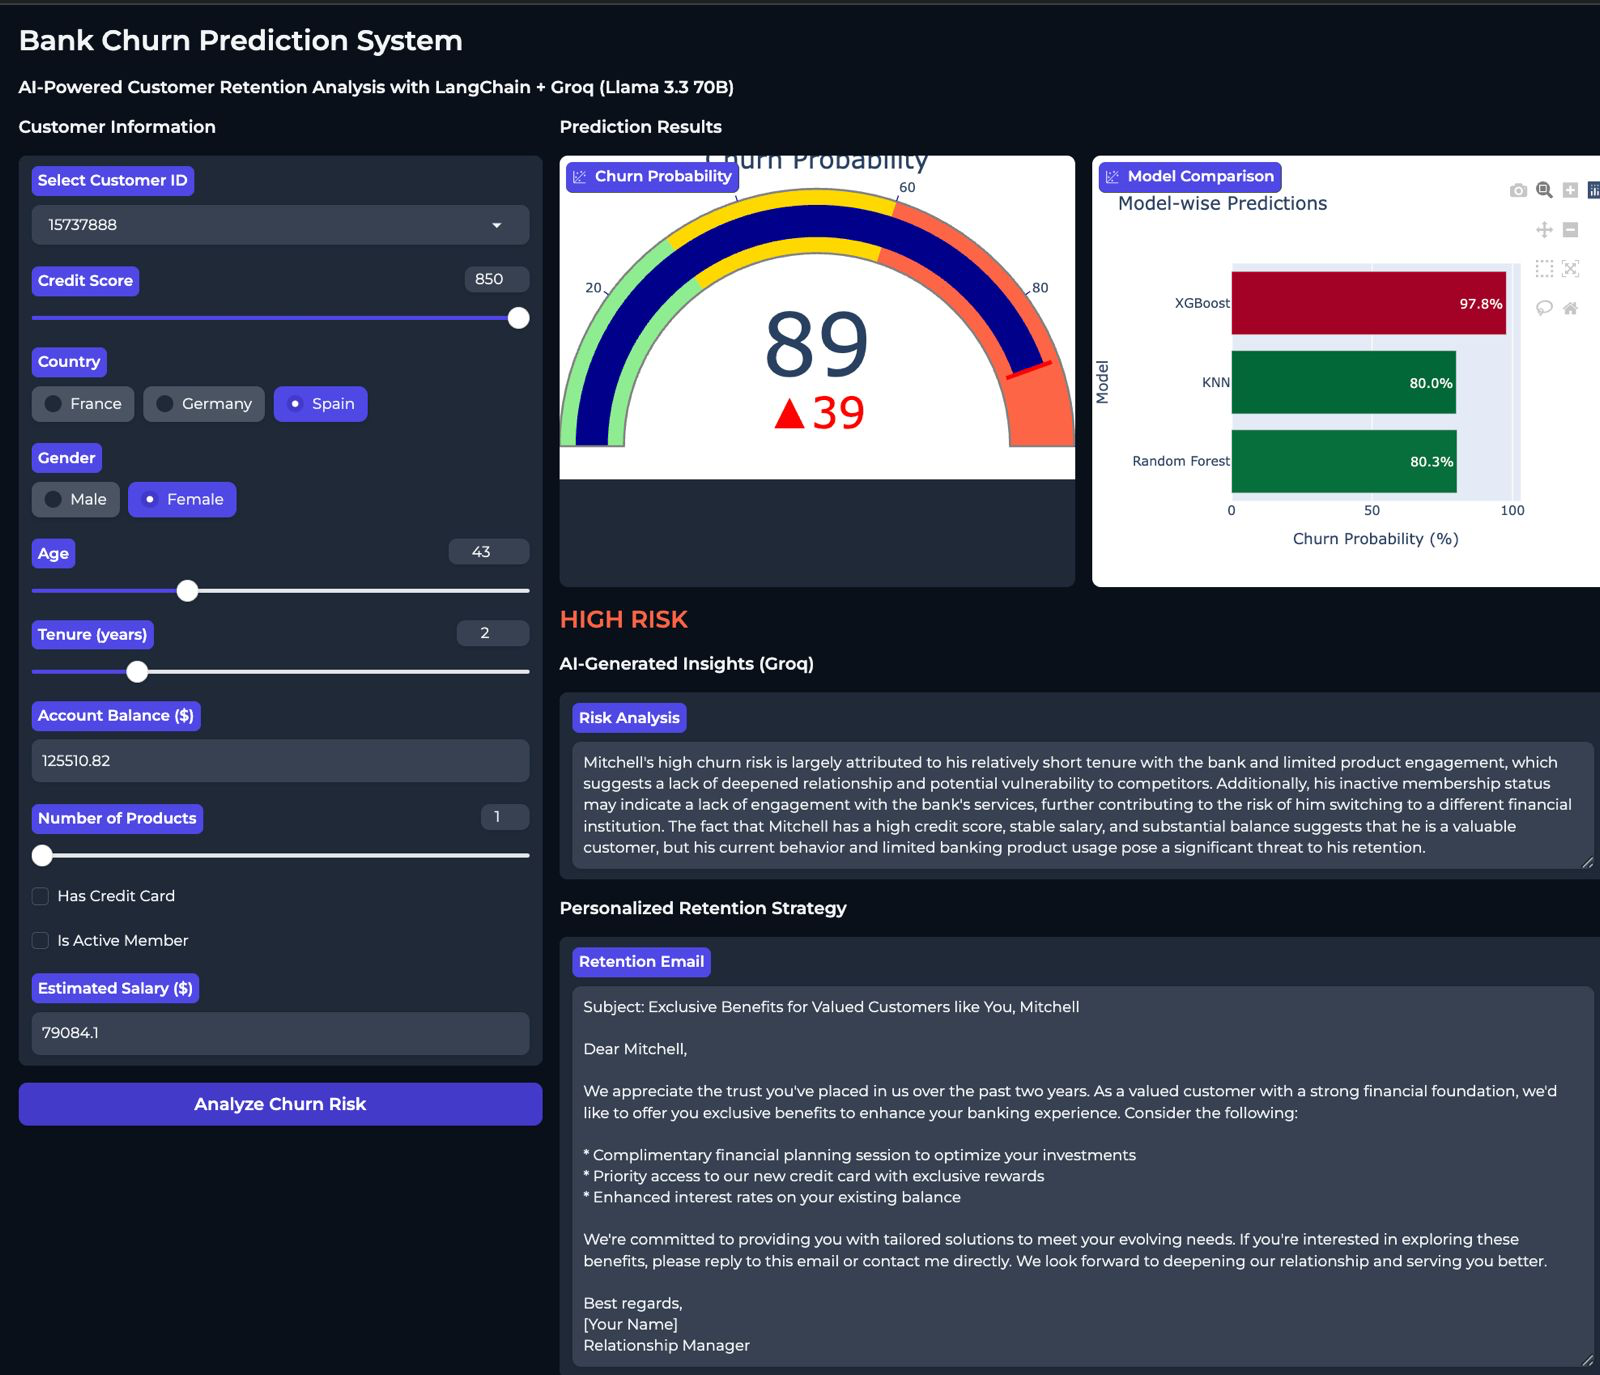

#### RISK PREDICTION :

Average probabilty of top three models > 0.6 then the model predicts HIGH RISK.
Average probabilty of top three models > 0.3 then the model predicts MEDIUM RISK.
Else it predicts LOW RISK (< 0.3)

The model can provide effective utility for use cases beyond solely predictive actions. Risk
prediction of customer churn can lead to and signal entry into customer buckets of low, medium, and
high risk, with streamlining of single customer risk email based retention communications involving
LLM(Langchain + Groq Llama 3.3 70B) to end possibly incorporated into the model to provide
retention risk based on churn associated key attributes predictive of the customer. Predictive
actions and effective customer communication may provide banks with proactive approaches to customer retention.
Various supervised learning models—Logistic Regression, KNN, Decision Tree, Random Forest, SVM, and XGBoost—were also trained and tested, and SMOTE and ADASYN were employed to counter the issue of imbalance to distinctly enhance the recall and F1 scores to Random Forest with SMOTE. These models were further incorporated into a “Bank Churn Prediction System” utilizing LangChain with LLaMA 3.3 to calculate the probabilities of customer churn, comparative assessments for each model, explanations for risk levels expressed through natural language rituals, and automated and semiautomated customized communication for the client retention professionals to make the machine learning process a suitable AI aid for their operations. 

## Achievements of Project

This project constructed an end-to-end customer churn prediction model for the retail banking company from raw data provided by Kaggle and delivered an exploratory decision-support tool. First, the team assembled and pre-processed 10,000 customer records by discarding non-prediction identifying information, addressing the presence of outliers in age and credit score, scaling numeric variables, and generating features including one-hot encoded geography and an active flag indicating gender, which were both informed by exploratory data analysis of the major drivers of customer churn and the problem of class imbalance.

## Future Scope

Future Scope and Improvements The future could see an extension to the data and models side by including the use of transactional data, usage data, and time-series data, and the use of more sophisticated architectures including gradient boosting algorithms that are calibrated, explainability solutions including SHAP analyis, and automated retraining processes. On the application side, the system can be developed to offer an end-to-end solution to banking systems and customer relationship management systems integrated with the LLM to not only compose the email but also offer next best actions, suggestions to evaluate the effects of various retention tactics, and learn from the feedback received regarding the effectiveness of retention efforts on those targeted for reduction in the process of customer churn.

## Insights and Conclusions

The improvement in predictive performance for customer churn due to class imbalance mitigation
is evidenced in the charts provided. Accuracy may be adequate in baseline models, while recall
may not be, indicating an inability to flag churned customers. The integration of SMOTE and
ADASYN contributed to an uplift in recall and F1 scores for most models due to an improvement
in the class of customers that are detectible at risk of churn. Hypothetically, all models created
under the SMOTE models within the Random Forest class provided the most optimal performance
due to the model comparison F1 and ROC-AUC score metrics for all models.
The model can provide effective utility for use cases beyond solely predictive actions. Risk
prediction of customer churn can lead to and signal entry into customer buckets of low, medium, and
high risk, with streamlining of single customer risk email based retention communications involving
LLM to end possibly incorporated into the model to provide retention risk based on churn associated
key attributes predictive of the customer. Predictive actions and effective customer communication
may provide banks with proactive approaches to customer retention.

# THANK YOU